 ##                            Recruit Restaurant Visitor Forecasting
 ##               Team 01 - Amrita Sharma, Anubha Varshney, Soundharya Murali

### 1.Importing data

In [447]:
#Importing packages needed for analysis
import numpy as np
import pandas as pd
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from sklearn import metrics
from xgboost import XGBRegressor
import math

In [448]:
# Importing data files
air_reserve = pd.read_csv('./air_reserve.csv')
air_store_info = pd.read_csv('./air_store_info.csv')
air_visit_data = pd.read_csv('./air_visit_data.csv')
date_info = pd.read_csv('./date_info.csv')
hpg_reserve = pd.read_csv('./hpg_reserve.csv')
hpg_store_info = pd.read_csv('./hpg_store_info.csv')
sample_submission = pd.read_csv('./sample_submission.csv')
store_id_relation = pd.read_csv('./store_id_relation.csv')

In [449]:
air_store_info.head(5)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


### 2. Data Preparation and Understanding

In [450]:
#Checking the dates available in the data
print ("Holiday data available for : " + str(len(date_info)) + " days")
print (max(date_info['calendar_date']),min(date_info['calendar_date']))
cnt=0
bm = date_info['holiday_flg']==1
print ("Holidays in data:",len(date_info[bm]))

#12th march - 22nd april also as test set
#23rd april 2017 - 31st may 2017 --> we should predict
#2016-12-29----2017-01-03

Holiday data available for : 517 days
2017-05-31 2016-01-01
Holidays in data: 35


In [451]:
# Converting the date columns in air_reserve to datetimeindex to split time from date
air_reserve.head()
visit = pd.DatetimeIndex(air_reserve['visit_datetime'])
reserve = pd.DatetimeIndex(air_reserve['reserve_datetime'])
air_reserve['visit_date'] = visit.date
air_reserve['reserve_date'] = reserve.date
air_reserve = air_reserve.drop(['visit_datetime','reserve_datetime','reserve_date'], axis= 1)
air_reserve.head()

,air_store_id,reserve_visitors,visit_date
0,air_877f79706adbfb06,1,2016-01-01
1,air_db4b38ebe7a7ceff,3,2016-01-01
2,air_db4b38ebe7a7ceff,6,2016-01-01
3,air_877f79706adbfb06,2,2016-01-01
4,air_db80363d35f10926,5,2016-01-01


In [452]:
#Checking the max and min dates available in the data
print (max(air_reserve['visit_date']),min(air_reserve['visit_date']))

2017-05-31 2016-01-01


In [453]:
# Converting the date columns in hpg_reserve to datetimeindex to split time from date
hpg_reserve.head()
visit = pd.DatetimeIndex(hpg_reserve['visit_datetime'])
hpg_reserve['visit_date'] = visit.date
del hpg_reserve['visit_datetime']
del hpg_reserve['reserve_datetime']
hpg_reserve.head()

,hpg_store_id,reserve_visitors,visit_date
0,hpg_c63f6f42e088e50f,1,2016-01-01
1,hpg_dac72789163a3f47,3,2016-01-01
2,hpg_c8e24dcf51ca1eb5,2,2016-01-01
3,hpg_24bb207e5fd49d4a,5,2016-01-01
4,hpg_25291c542ebb3bc2,13,2016-01-01


In [454]:
#Summing up the reserved visitors after removing time from date
air = pd.DataFrame(air_reserve.groupby(['air_store_id','visit_date'],as_index=False)['reserve_visitors'].sum())
hpg = pd.DataFrame(hpg_reserve.groupby(['hpg_store_id','visit_date'],as_index=False)['reserve_visitors'].sum())

In [455]:
#Checking count of rows in dataframes
df1 = pd.DataFrame(air_reserve['air_store_id'].str[4:])
print (len(df1)) #92378
print (len(df1.air_store_id.unique())) #314

df2 = pd.DataFrame(hpg_reserve['hpg_store_id'].str[4:])
print (len(df2)) #92378
print (len(df2.hpg_store_id.unique())) #314

92378
314
2000320
13325


In [456]:
#Renaming columns so as to merge air and hog data
air = air.rename(index=str, columns={"reserve_visitors": "air_visitors"})
hpg = hpg.rename(index=str, columns={"reserve_visitors": "hpg_visitors"})
air_df = pd.merge(air,store_id_relation)
print (len(air)) #29830
print (len(air_df)) #12646 store-date combinations had hpg mapping
air_hpg = pd.merge(air_df,hpg)
print (len(air_hpg)) #6257 combinations had corresponding visitor data
air_hpg.head()

29830
12646
6257


,air_store_id,visit_date,air_visitors,hpg_store_id,hpg_visitors
0,air_00a91d42b08b08d9,2016-10-31,2,hpg_fbe603376b5980fc,2
1,air_00a91d42b08b08d9,2016-12-05,9,hpg_fbe603376b5980fc,1
2,air_00a91d42b08b08d9,2016-12-17,2,hpg_fbe603376b5980fc,2
3,air_00a91d42b08b08d9,2016-12-20,4,hpg_fbe603376b5980fc,4
4,air_00a91d42b08b08d9,2017-02-18,9,hpg_fbe603376b5980fc,9


#### Adding air and hpg reservations to get total reserved visitors per store per day

In [457]:
#Summing up total reservations
air_hpg['reserved_visitors'] = air_hpg['air_visitors'] + air_hpg['hpg_visitors']
air_hpg = air_hpg[['air_store_id','visit_date','reserved_visitors']]
air_hpg.head()

,air_store_id,visit_date,reserved_visitors
0,air_00a91d42b08b08d9,2016-10-31,4
1,air_00a91d42b08b08d9,2016-12-05,10
2,air_00a91d42b08b08d9,2016-12-17,4
3,air_00a91d42b08b08d9,2016-12-20,8
4,air_00a91d42b08b08d9,2017-02-18,18


#### Merge just air reservations with air& hpg reservations and create one table for reservations

In [458]:
just_air = pd.merge(df3,air)
just_air = just_air.rename(index=str, columns={"air_visitors": "reserved_visitors"})
#print (just_air.head())
all_air_hpg = pd.concat([air_hpg,just_air])
print (len(all_air_hpg))
all_air_hpg.head()

29830


,air_store_id,visit_date,reserved_visitors
0,air_00a91d42b08b08d9,2016-10-31,4
1,air_00a91d42b08b08d9,2016-12-05,10
2,air_00a91d42b08b08d9,2016-12-17,4
3,air_00a91d42b08b08d9,2016-12-20,8
4,air_00a91d42b08b08d9,2017-02-18,18


#### Final dataframe with all columns

In [459]:
visit = pd.DatetimeIndex(air_visit_data['visit_date'])
air_visit_data['visit_date'] = visit.date
print (len(air_visit_data))
visit_reserve = pd.merge(air_visit_data,all_air_hpg,how='left').fillna(0)
print (len(visit_reserve[visit_reserve['reserved_visitors']>0]))
print (len(visit_reserve))

252108
28064
252108


*Hence, for all the restaurants where there is a record of the reservations, we also have the effective number of visitors. However, there is ~ 500 restaurants for which we don't have any informations on reservations.*

#### Outlier treatment for visitors and reserved visitors

In [460]:
visit_reserve.loc[visit_reserve['reserved_visitors'] > 300] = visit_reserve['reserved_visitors'].quantile(.998)
visit_reserve.loc[visit_reserve['visitors'] > 500] = visit_reserve['reserved_visitors'].quantile(.998)

#### Add date_info to the visit_reserve table

In [461]:
date_info = date_info.rename(index=str, columns={"calendar_date": "visit_date"})
visit = pd.DatetimeIndex(date_info['visit_date'])
date_info['visit_date'] = visit.date
#print (date_info.head())

#print (visit_reserve.head())
visit_reserve = pd.merge(visit_reserve,date_info)
print (len(visit_reserve))

# Splitting date into day,month and year
visit_reserve['year'] = pd.DatetimeIndex(visit_reserve['visit_date']).year
visit_reserve['month'] = pd.DatetimeIndex(visit_reserve['visit_date']).month
visit_reserve['day'] = pd.DatetimeIndex(visit_reserve['visit_date']).day

252098


#### Merging with air_store_info to get store features

In [462]:
print (len(visit_reserve))
visit_reserve = pd.merge(visit_reserve,air_store_info)

252098


#### One hot encoding of categorical variables

In [463]:
genre = pd.get_dummies(visit_reserve['air_genre_name'])
visit_reserve = visit_reserve.join(genre)

day = pd.get_dummies(visit_reserve['day_of_week'])
visit_reserve = visit_reserve.join(day)

In [384]:
# Store ids are mapped to numbers from alpha numeric characters
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
store = pd.DataFrame(label_encoder.fit_transform(visit_reserve['air_store_id']))
visit_reserve['store_id'] = store

print (visit_reserve.head())
print (len(visit_reserve))

           air_store_id  visit_date  visitors  reserved_visitors day_of_week  \
0  air_ba937bf13d40fb24  2016-01-13      25.0                0.0   Wednesday   
1  air_ba937bf13d40fb24  2016-01-14      32.0                0.0    Thursday   
2  air_ba937bf13d40fb24  2016-01-15      29.0                0.0      Friday   
3  air_ba937bf13d40fb24  2016-01-16      22.0                0.0    Saturday   
4  air_ba937bf13d40fb24  2016-01-18       6.0                0.0      Monday   

   holiday_flg  year  month  day air_genre_name    ...    Western food  \
0            0  2016      1   13     Dining bar    ...               0   
1            0  2016      1   14     Dining bar    ...               0   
2            0  2016      1   15     Dining bar    ...               0   
3            0  2016      1   16     Dining bar    ...               0   
4            0  2016      1   18     Dining bar    ...               0   

   Yakiniku/Korean food  Friday  Monday  Saturday  Sunday  Thursday  Tuesd

#### Splitting into train and test datasets

In [386]:
#Data available from Jan1-2016 to Apr22-2017. So taking data from March 10-2017 as test
train_dataset = visit_reserve.loc[visit_reserve['visit_date'] < datetime.date(2017,3,10)]
print (max(train_dataset['visit_date']),min(train_dataset['visit_date']))

test_dataset = visit_reserve.loc[visit_reserve['visit_date'] > datetime.date(2017,3,10)]
print (max(test_dataset['visit_date']),min(test_dataset['visit_date']))

print (len(train_dataset.columns))
#train_dataset.head()

2017-03-09 2016-01-01
2017-04-22 2017-03-11
35


### Visualizing the data

#### Location of restaurants in Japan (code taken from online)

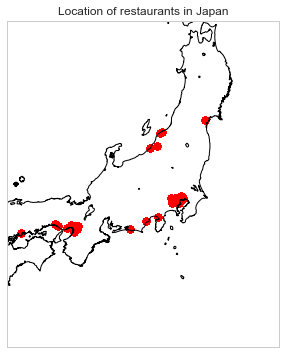

In [387]:
## Checking if the restaurants lie in Japan 
from mpl_toolkits.basemap import Basemap

latitude = train_dataset['latitude'].values
longitude = train_dataset['longitude'].values

fig = plt.figure(figsize=(6, 6))
map_plot = Basemap(projection='lcc', resolution='h',lat_0=36.2048, lon_0=138.2529,width=1000000, height=1200000)

map_plot.drawcoastlines(color='black')
map_plot.drawcountries(color='black')
map_plot.scatter(longitude, latitude, latlon=True, alpha=0.5,color="red")
plt.title("Location of restaurants in Japan")
plt.show()

*It can be clearly seen that there are no restaurants which are considered outside Japan*

#### Adding a column for popularity of a restaurant

In [388]:
store_popularity = train_dataset.groupby('air_store_id')['visitors'].sum()
store_popularity = store_popularity.reset_index().rename(columns={'visitors': 'total_visitors'})
store_popularity.head()

,air_store_id,total_visitors
0,air_00a91d42b08b08d9,5009.0
1,air_0164b9927d20bcc3,1052.0
2,air_0241aa3964b7f861,3593.0
3,air_0328696196e46f18,690.0
4,air_034a3d5b40d5b1b1,2699.0


In [389]:
print (store_popularity['total_visitors'].quantile(.2))
print (store_popularity['total_visitors'].quantile(.4))
print (store_popularity['total_visitors'].quantile(.6))
print (store_popularity['total_visitors'].quantile(.8))
#print (store_popularity['total_visitors'].quantile(.2))

2456.0
3980.800000000001
5616.999999999998
8191.000000000001


In [391]:
store_popularity['popularity'] = pd.cut(store_popularity['total_visitors'], [0, 4000, 8000, 12000,16000,20000], 
                                        labels=['Very low', 'Low', 'Medium','High' ,'Very high'])
#store_popularity['popularity'].value_counts()

#### Joining popularity with train_dataset

In [392]:
train_dataset = pd.merge(train_dataset, store_popularity)
train_dataset.head()

,air_store_id,visit_date,visitors,reserved_visitors,day_of_week,holiday_flg,year,month,day,air_genre_name,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,store_id,total_visitors,popularity
0,air_ba937bf13d40fb24,2016-01-13,25.0,0.0,Wednesday,0,2016,1,13,Dining bar,...,0,0,0,0,0,0,1,603,8183.0,Medium
1,air_ba937bf13d40fb24,2016-01-14,32.0,0.0,Thursday,0,2016,1,14,Dining bar,...,0,0,0,0,1,0,0,603,8183.0,Medium
2,air_ba937bf13d40fb24,2016-01-15,29.0,0.0,Friday,0,2016,1,15,Dining bar,...,1,0,0,0,0,0,0,603,8183.0,Medium
3,air_ba937bf13d40fb24,2016-01-16,22.0,0.0,Saturday,0,2016,1,16,Dining bar,...,0,0,1,0,0,0,0,603,8183.0,Medium
4,air_ba937bf13d40fb24,2016-01-18,6.0,0.0,Monday,0,2016,1,18,Dining bar,...,0,1,0,0,0,0,0,603,8183.0,Medium


### Reserve v/s Visit Data

We need to compare and see the trend for Visit data versus the reservation data. We expect to see that the days when we had higher number of visitors should also have higher number of of reservations.

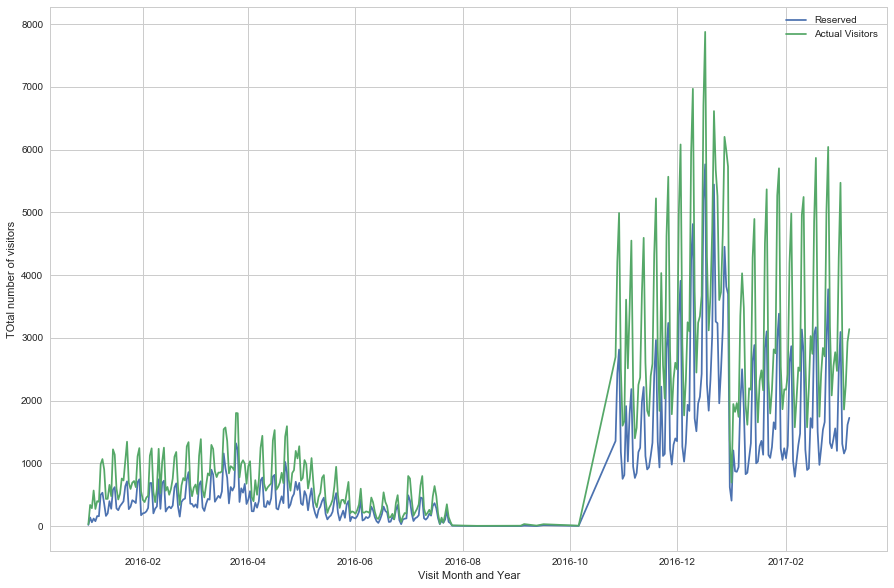

In [428]:
# Get the reservation data only for those dates where the reservation data is available.
res_data = train_dataset[["visit_date","visitors", "reserved_visitors"]]
res_data = res_data[res_data['reserved_visitors'] > 0 ]
# Get the total reserved visitors for all stores for each reservation date
res_data_plot = res_data.groupby('visit_date').apply(lambda df: sum(df['reserved_visitors']))
# Get the total actual visitors for all stores for each visit date
visit_data_plot = res_data.groupby('visit_date').apply(lambda df: sum(df['visitors']))
plt.figure(figsize=(15,10))
plt.plot(res_data_plot, label = 'Reserved')
plt.plot(visit_data_plot, label = 'Actual Visitors')
plt.xlabel('Visit Month and Year')
plt.ylabel('TOtal number of visitors')
plt.legend()
plt.show()

There is a clear time series trend in the data. The number for visitors and reservation is lower in the initial part of July after which we see a jump in the reservations and visitor numbers. The gap in the reservated and visited numbers from July to August,2016 is due to unavailability of the reservation data during that period.

The continuous surge and drops in the number is clear sign of weekly seasonality. Also the reservation and visit data seem to varying similarly so we can expect the reservation information to be an important parameter to predict the visitors. 

#### Day of the week data

Analyzing the day of the week to understand which days have higher number of visitors. We expect to see that weekends will generally have higher number of visitors. And as can be seen in the graph that Saturday has highest vistors followed by Sunday and Friday.

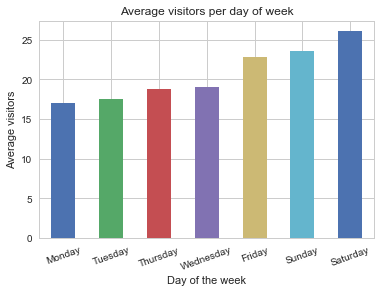

In [429]:
# without removing the missing data for reservation 
dow_data = train_dataset[["day_of_week","visitors"]]
dow_data_plot = dow_data.groupby('day_of_week')['visitors'].mean().sort_values() 

# fig, ax = plt.subplots()
# ax.barh(y_pos, performance,align='center',
#         color='green', ecolor='black')
dow_data_plot.plot.bar(sort_columns = True)
plt.title('Average visitors per day of week')
plt.xticks(rotation = 20)
plt.ylabel('Average visitors')
plt.xlabel('Day of the week')
plt.show()

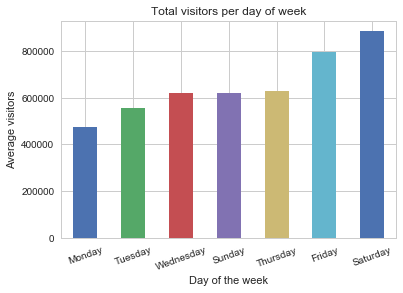

In [465]:
# without removing the missing data for reservation 
dow_data = train_dataset[["day_of_week","visitors"]]
dow_data_plot = dow_data.groupby('day_of_week')['visitors'].sum().sort_values() 

# fig, ax = plt.subplots()
# ax.barh(y_pos, performance,align='center',
#         color='green', ecolor='black')
dow_data_plot.plot.bar(sort_columns = True)
plt.title('Total visitors per day of week')
plt.xticks(rotation = 20)
plt.ylabel('Average visitors')
plt.xlabel('Day of the week')
plt.show()

In [431]:
dow_data_plot

day_of_week
Monday       474928.0
Tuesday      557290.0
Wednesday    618776.0
Sunday       621321.0
Thursday     629464.0
Friday       795401.0
Saturday     883786.0
Name: visitors, dtype: float64

### EDA for Genre and Area of restaurant

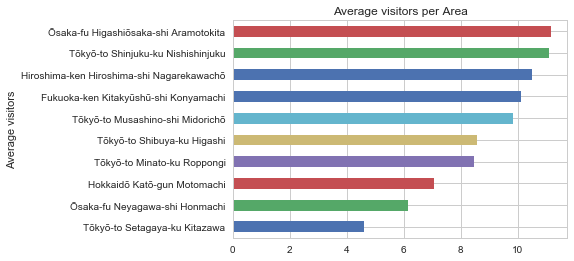

In [432]:
# Average visitors for top 10 areas of  the restaurants
genre_data = train_dataset[["air_area_name","visitors"]]
genre_data_plot = genre_data.groupby('air_area_name')['visitors'].mean().sort_values()

genre_data_plot[:10].plot.barh()
plt.title('Average visitors per Area')
plt.ylabel('Average visitors')
plt.show()

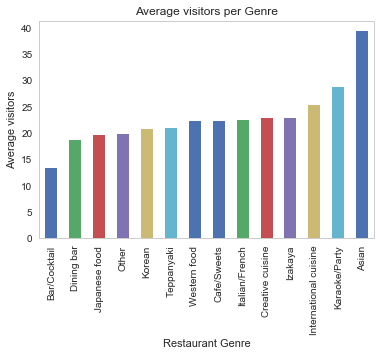

In [444]:
# Average visitors for top 10 areas of  the restaurants
# plt.figure(figsize = (7,7))
genre_data = train_dataset[["air_genre_name","visitors"]]
# genre_data["air_genre_name"] = 
d = {'Okonomiyaki/Monja/Teppanyaki': 'Teppanyaki', 'Yakiniku/Korean food' : 'Korean'}
genre_data =  genre_data.replace(d)
genre_data_plot = genre_data.groupby('air_genre_name')['visitors'].mean().sort_values()

#genre_data_plot.plot.bar()
genre_data_plot.plot(kind = 'bar')
plt.grid(False)
plt.xticks(rotation = 90)
plt.title('Average visitors per Genre')
plt.xlabel('Restaurant Genre')
plt.ylabel('Average visitors')
plt.show()

### Evaluation metrics - RMSLE & RMSE functions

In [394]:
#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

### 3. Methodology

### Time Series Approach

##### ARIMA

In [434]:
import warnings
warnings.filterwarnings("ignore")

In [435]:
visit_reserve["visit_date"] = pd.to_datetime(visit_reserve["visit_date"], format="%Y/%m/%d")
data = visit_reserve[["visit_date","visitors"]]
data_visitors = data.groupby('visit_date').apply(lambda df: sum(df['visitors']))

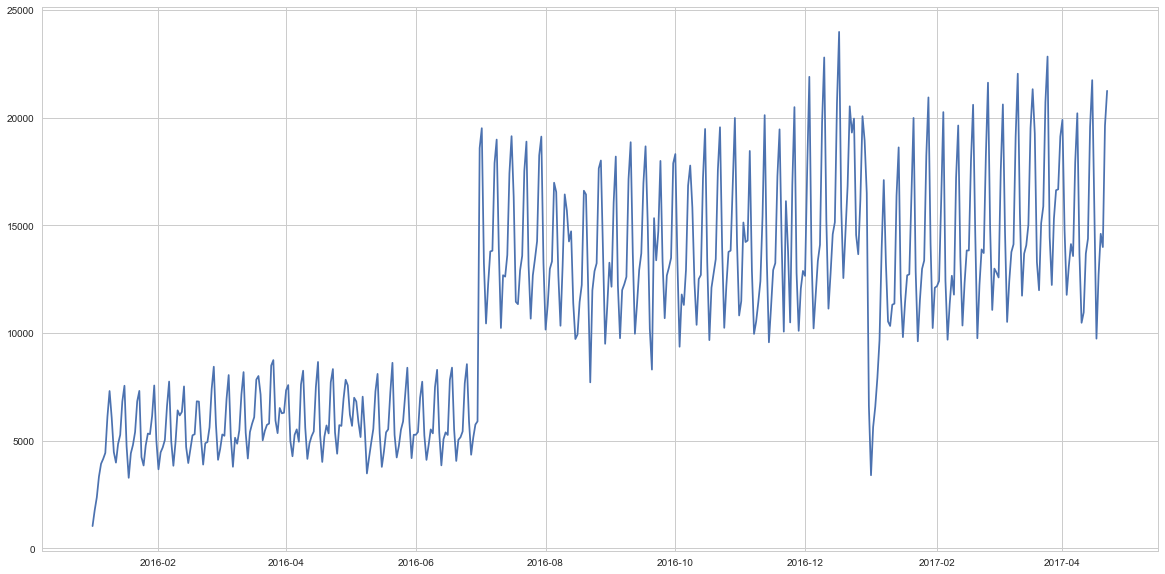

In [436]:
plt.figure(figsize=(20,10))
plt.plot(data_visitors)

In [437]:
from statsmodels.tsa.arima_model import ARIMA

In [438]:
t_store_id = test_dataset['air_store_id'].drop_duplicates()
t_store_id = t_store_id.tolist()
print (len(t_store_id))

821


In [439]:
rmsle_list,rmse_list =[],[]
for store in t_store_id:
    store_df = visit_reserve.loc[visit_reserve['air_store_id'] == store]
    store_df = store_df[["visit_date","visitors"]]

    store_df_ts = store_df.set_index('visit_date')
    ts = store_df_ts['visitors'].astype('float')
    
    size = int(len(ts) * 0.90)
    train, test = ts[0:size], ts[size:len(ts)]
    #history = [x for x in train]
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(ts, order=(0,1,1))
        #model = ARIMA(ts)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        pred = output[0]
        predictions.append(pred)
        obs = test[t]
        
    rmsle_list.append(rmsle(test,predictions))
    rmse_list.append(sqrt(mean_squared_error(test,predictions)))
#error = mean_squared_error(test, predictions)
print ("ARIMA results:")
print ("Final RMSLE score:",np.mean(rmsle_list))
print ("Final RMSE score:",np.mean(rmse_list))

ARIMA results:
Final RMSLE score: 0.599611664679
Final RMSE score: 11.0930864588


##### GPRegression

In [395]:
#Running separate regressions store-wise and averaging out the RMSLE at the end
from sklearn import gaussian_process
rmsle_list,rmse_list =[],[]
for store in t_store_id:
    pred,expect =[],[]
    store_df_train = train_dataset.loc[train_dataset['air_store_id'] == store]
    x_train = pd.DataFrame(store_df_train[['day','month','year']])
    y_train = pd.DataFrame(store_df_train[['visitors']])
    
    store_df_test = test_dataset.loc[test_dataset['air_store_id'] == store]
    x_test = pd.DataFrame(store_df_test[['day','month','year']])
    y_test = pd.DataFrame(store_df_test[['visitors']])
    
    gp = gaussian_process.GaussianProcessRegressor()
    gp.fit(x_train, y_train)
    predicted = gp.predict(x_test)
    expected = np.array(y_test)
    
    for i in predicted:
        for j in i:
            if j<0:
                j=0
            pred.append(j)

    for i in expected:
        for j in i:
            expect.append(j+1)
    rmsle_list.append(rmsle(expect,pred))
    rmse_list.append(sqrt(mean_squared_error(expect,pred)))
print ("Final RMSLE score:",np.mean(rmsle_list))
print ("Final RMSE score:",np.mean(rmse_list))

Final RMSLE score: 1.46572630732
Final RMSE score: 18.280202269


#### Adding all the store and date level features to GP Regression

In [396]:
rmsle_list,rmse_list =[],[]
for store in t_store_id:
    pred,expect =[],[]
    store_df_train = train_dataset.loc[train_dataset['air_store_id'] == store]
    x_train = pd.DataFrame(store_df_train[['day','month','year',
                                      'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                                      'holiday_flg','Dining bar', 'Izakaya','Cafe/Sweets', 'Italian/French','Other', 
                                        'Yakiniku/Korean food','Japanese food','Okonomiyaki/Monja/Teppanyaki',
                                            'Bar/Cocktail', 'Creative cuisine',
                                            'Western food', 'Asian',
                                            'International cuisine', 'Karaoke/Party','reserved_visitors','latitude','longitude' ]])
    y_train = pd.DataFrame(store_df_train[['visitors']])
    
    store_df_test = test_dataset.loc[test_dataset['air_store_id'] == store]
    x_test = pd.DataFrame(store_df_test[['day','month','year',
                                      'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                                      'holiday_flg','Dining bar', 'Izakaya','Cafe/Sweets', 'Italian/French','Other', 
                                        'Yakiniku/Korean food','Japanese food','Okonomiyaki/Monja/Teppanyaki',
                                            'Bar/Cocktail', 'Creative cuisine',
                                            'Western food', 'Asian',
                                            'International cuisine', 'Karaoke/Party','reserved_visitors','latitude','longitude' ]])
    y_test = pd.DataFrame(store_df_test[['visitors']])
    
    gp = gaussian_process.GaussianProcessRegressor()
    gp.fit(x_train, y_train)
    predicted = gp.predict(x_test)
    expected = np.array(y_test)
    
    for i in predicted:
        for j in i:
            if j<0:
                j=0
            pred.append(j)

    for i in expected:
        for j in i:
            expect.append(j+1)
    #print (expect,pred)
    #print (rmsle(expect,pred))
    rmsle_list.append(rmsle(expect,pred))
    rmse_list.append(sqrt(mean_squared_error(expect,pred)))

print ("Final RMSLE score:",np.mean(rmsle_list))
print ("Final RMSE score:",np.mean(rmse_list))

Final RMSLE score: 1.59031576444
Final RMSE score: 19.7138964014


### Decision Trees and Ensemble Modeling 

##### Decision Tree Regression

In [397]:
from sklearn.tree import DecisionTreeRegressor
#Running separate regressions store-wise and averaging out the RMSLE at the end
rmsle_list,rmse_list =[],[]
for store in t_store_id:
    pred,expect =[],[]
    store_df_train = train_dataset.loc[train_dataset['air_store_id'] == store]
    x_train = pd.DataFrame(store_df_train[['store_id','day','month','year',
                                      'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                                      'holiday_flg','Dining bar', 'Izakaya','Cafe/Sweets', 'Italian/French','Other', 
                                        'Yakiniku/Korean food','Japanese food','Okonomiyaki/Monja/Teppanyaki',
                                            'Bar/Cocktail', 'Creative cuisine',
                                            'Western food', 'Asian',
                                            'International cuisine', 'Karaoke/Party','reserved_visitors',
                                           'latitude','longitude' ]])
    y_train = pd.DataFrame(store_df_train[['visitors']])
    
    store_df_test = test_dataset.loc[test_dataset['air_store_id'] == store]
    x_test = pd.DataFrame(store_df_test[['store_id','day','month','year',
                                      'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                                      'holiday_flg','Dining bar', 'Izakaya','Cafe/Sweets', 'Italian/French','Other', 
                                        'Yakiniku/Korean food','Japanese food','Okonomiyaki/Monja/Teppanyaki',
                                            'Bar/Cocktail', 'Creative cuisine',
                                            'Western food', 'Asian',
                                            'International cuisine', 'Karaoke/Party','reserved_visitors',
                                         'latitude','longitude' ]])
    y_test = pd.DataFrame(store_df_test[['visitors']])
    
    dc = DecisionTreeRegressor(max_depth=10,criterion="mse")
    dc.fit(x_train, y_train)
    predicted = dc.predict(x_test)
    expected = np.array(y_test)
    
    for i in predicted:
        if i<0:
            i=0
        pred.append(i)
    
    for i in expected:
        for j in i:
            expect.append(j)
    rmsle_list.append(rmsle(expect,pred))
    rmse_list.append(sqrt(mean_squared_error(expect,pred)))
print ("Decision Tree:")
print ("Final RMSLE score:",np.mean(rmsle_list))
print ("Final RMSE score:",np.mean(rmse_list))

Decision Tree:
Final RMSLE score: 0.60978356157
Final RMSE score: 11.6683733071


##### Random Forest

In [398]:
from sklearn.ensemble import RandomForestRegressor
#Running separate regressions store-wise and averaging out the RMSLE at the end
rmsle_list,rmse_list =[],[]
for store in t_store_id:
    pred,expect =[],[]
    store_df_train = train_dataset.loc[train_dataset['air_store_id'] == store]
    x_train = pd.DataFrame(store_df_train[['store_id','day','month','year',
                                      'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                                      'holiday_flg','Dining bar', 'Izakaya','Cafe/Sweets', 'Italian/French','Other', 
                                        'Yakiniku/Korean food','Japanese food','Okonomiyaki/Monja/Teppanyaki',
                                            'Bar/Cocktail', 'Creative cuisine',
                                            'Western food', 'Asian',
                                            'International cuisine', 'Karaoke/Party','reserved_visitors',
                                           'latitude','longitude' ]])
    y_train = pd.DataFrame(store_df_train[['visitors']])
    
    store_df_test = test_dataset.loc[test_dataset['air_store_id'] == store]
    x_test = pd.DataFrame(store_df_test[['store_id','day','month','year',
                                      'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                                      'holiday_flg','Dining bar', 'Izakaya','Cafe/Sweets', 'Italian/French','Other', 
                                        'Yakiniku/Korean food','Japanese food','Okonomiyaki/Monja/Teppanyaki',
                                            'Bar/Cocktail', 'Creative cuisine',
                                            'Western food', 'Asian',
                                            'International cuisine', 'Karaoke/Party','reserved_visitors',
                                         'latitude','longitude' ]])
    y_test = pd.DataFrame(store_df_test[['visitors']])
    
    rf = RandomForestRegressor(criterion="mse",n_estimators=200,max_depth=10)
    rf.fit(x_train, y_train)
    predicted = rf.predict(x_test)
    expected = np.array(y_test)
    
    for i in predicted:
        if i<0:
            i=0
        pred.append(i)
    
    for i in expected:
        for j in i:
            expect.append(j)
    rmsle_list.append(rmsle(expect,pred))
    rmse_list.append(sqrt(mean_squared_error(expect,pred)))
print ("Random Forest:")
print ("Final RMSLE score:",np.mean(rmsle_list))
print ("Final RMSE score:",np.mean(rmse_list))

Random Forest:
Final RMSLE score: 0.50577767035
Final RMSE score: 9.54229562472


##### XG Boost

#### Code for baseline model of XGBoost

In [399]:
#Running separate regressions store-wise and averaging out the RMSLE at the end
rmsle_list,rmse_list =[],[]
for store in t_store_id:
    pred,expect =[],[]
    store_df_train = train_dataset.loc[train_dataset['air_store_id'] == store]
    x_train = pd.DataFrame(store_df_train[['day','month','year']])
    y_train = pd.DataFrame(store_df_train[['visitors']])
    
    store_df_test = test_dataset.loc[test_dataset['air_store_id'] == store]
    x_test = pd.DataFrame(store_df_test[['day','month','year']])
    y_test = pd.DataFrame(store_df_test[['visitors']])
    
    xgb_basemodel = XGBRegressor(learning_rate=0.2,n_estimators=300,max_depth=1)
    xgb_basemodel.fit(x_train, y_train)
    predicted = xgb_basemodel.predict(x_test)
    expected = np.array(y_test)
    
    for i in predicted:
        if i<0:
            i=0
        pred.append(i)
    
    for i in expected:
        for j in i:
            expect.append(j)
    rmsle_list.append(rmsle(expect,pred))
    rmse_list.append(sqrt(mean_squared_error(expect,pred)))
print ("Final RMSLE score:",np.mean(rmsle_list))
print ("Final RMSE score:",np.mean(rmse_list))

Final RMSLE score: 0.604883668246
Final RMSE score: 11.6307389558


#### XGBoost with all features and cross-validated parameters

In [261]:
#Running separate regressions store-wise and averaging out the RMSLE at the end
from sklearn.model_selection import GridSearchCV
rmsle_list,rmse_list,depths =[],[],[]
pred2,expect2 =[],[]
cv_params = {'max_depth': [1,2,3,4,5,6,7,8,9,10]}
for store in t_store_id:
    pred,expect =[],[]
    store_df_train = train_dataset.loc[train_dataset['air_store_id'] == store]
    x_train = pd.DataFrame(store_df_train[['store_id','day','month','year',
                                      'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                                      'holiday_flg','Dining bar', 'Izakaya','Cafe/Sweets', 'Italian/French','Other', 
                                        'Yakiniku/Korean food','Japanese food','Okonomiyaki/Monja/Teppanyaki',
                                            'Bar/Cocktail', 'Creative cuisine',
                                            'Western food', 'Asian',
                                            'International cuisine', 'Karaoke/Party','reserved_visitors']])
    y_train = pd.DataFrame(store_df_train[['visitors']])
    
    store_df_test = test_dataset.loc[test_dataset['air_store_id'] == store]
    x_test = pd.DataFrame(store_df_test[['store_id','day','month','year',
                                      'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                                      'holiday_flg','Dining bar', 'Izakaya','Cafe/Sweets', 'Italian/French','Other', 
                                        'Yakiniku/Korean food','Japanese food','Okonomiyaki/Monja/Teppanyaki',
                                            'Bar/Cocktail', 'Creative cuisine',
                                            'Western food', 'Asian',
                                            'International cuisine', 'Karaoke/Party','reserved_visitors']])
    y_test = pd.DataFrame(store_df_test[['visitors']])
    if (len(x_train)>= 10):
        xgb_model3 = XGBRegressor(learning_rate=0.2,n_estimators=300)
        optimized_GBM = GridSearchCV(xgb_model3,cv_params, cv = 5) 
        optimized_GBM.fit(x_train,y_train)
        best_depth = optimized_GBM.best_params_['max_depth']
        depths.append(best_depth)

        xgb_model4 = XGBRegressor(learning_rate=0.2,n_estimators=300,max_depth=best_depth)
        xgb_model4.fit(x_train,y_train)
        predicted = xgb_model4.predict(x_test)
        expected = np.array(y_test)

        for i in predicted:
            if i<0:
                i=0
            pred.append(i)
            pred2.append(i)

        for i in expected:
            for j in i:
                expect.append(j)
                expect2.append(j)
        rmsle_list.append(rmsle(expect,pred))
        rmse_list.append(sqrt(mean_squared_error(expect,pred)))
        
print ("Final RMSLE score:",np.mean(rmsle_list))
print ("Final RMSE score:",np.mean(rmse_list))

Final RMSLE score: 0.506706428296
Final RMSE score: 9.22132410672


### 4. Model Evaluation

In [401]:
removable_stores = []
for store in t_store_id:
    store_df_train = train_dataset.loc[train_dataset['air_store_id'] == store]
    if (len(store_df_train)< 10):
        removable_stores.append(store)

In [402]:
test_dataset = test_dataset[test_dataset['air_store_id'] != 'air_789103bf53b8096b' ]
test_dataset = test_dataset[test_dataset['air_store_id'] != 'air_cf5ab75a0afb8af9' ]
test_dataset = test_dataset[test_dataset['air_store_id'] != 'air_1c0b150f9e696a5f' ]
test_dataset = test_dataset[test_dataset['air_store_id'] != 'air_900d755ebd2f7bbd' ]
test_dataset = test_dataset[test_dataset['air_store_id'] != 'air_a17f0778617c76e2' ]
print (len(test_dataset))

30623


### Deep dive of results

#### Genre vs RMSLE

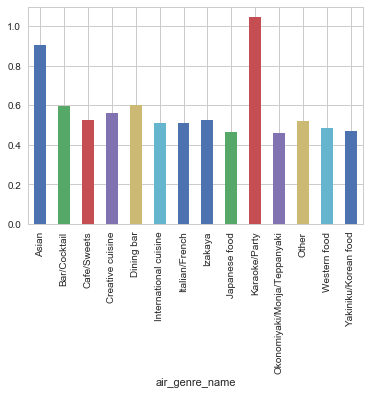

In [467]:
test_dataset['pred2'] = pred2
test_dataset['expect2'] = expect2
test_genre = test_dataset.groupby('air_genre_name').apply(lambda df:rmsle(np.array(df['visitors']),np.array(df['pred2'])))
#plt.figure(figsize=(20,10))
test_genre.plot(kind = 'bar')

#### Understanding error through day of the week

Text(0,0.5,'RMSE score')

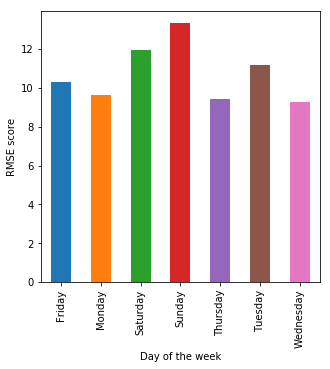

In [315]:
test_week = test_dataset.groupby('day_of_week').apply(lambda df:sqrt(mean_squared_error(np.array(df['visitors']),np.array(df['pred2']))))
plt.figure(figsize=(5,5))
test_week.plot(kind = 'bar')
plt.xlabel("Day of the week")
plt.ylabel("RMSE score")

In [326]:
# without removing the missing data for reservation 
dow_data = train_dataset[["day_of_week","visitors"]]
dow_data_plot = dow_data.groupby('day_of_week')['visitors'].mean().sort_values() 
day_avg_visitors = dow_data_plot.reset_index().rename(columns={'visitors': 'Average_Visitors'})

test_week = test_dataset.groupby('day_of_week').apply(lambda df:sqrt(mean_squared_error(np.array(df['visitors']),np.array(df['pred2']))))
day_rmse = test_week.reset_index().rename(columns={0: 'RMSE'})

In [360]:
from bokeh.plotting import figure,show
from bokeh.charts import Bar, output_file, show

# Use output_notebook if you are using an IPython or Jupyter notebook
from bokeh.io import output_notebook
output_notebook()

df = pd.merge(day_avg_visitors, day_rmse)
melted_df = pd.melt(df, id_vars=['day_of_week'], value_vars=['Average_Visitors','RMSE'])
melted_df = melted_df.rename(columns={'day_of_week':'Day of week','variable': 'Attributes','value':'Visitors'})

Loading BokehJS ...

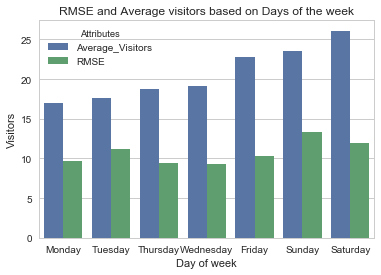

In [361]:
my_plot = sns.barplot(x="Day of week", y="Visitors",hue = "Attributes", 
                      data=melted_df).set_title(label="RMSE and Average visitors based on Days of the week")
plt.show()

Text(0,0.5,'RMSLE score')

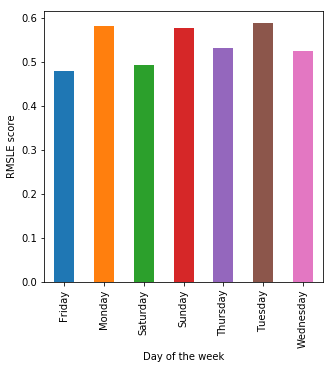

In [288]:
test_week = test_dataset.groupby('day_of_week').apply(lambda df:rmsle(np.array(df['visitors']),np.array(df['pred2'])))
plt.figure(figsize=(5,5))
test_week.plot(kind = 'bar')
plt.xlabel("Day of the week")
plt.ylabel("RMSLE score")

In [284]:
train_dataset.groupby('day_of_week').size().reset_index().rename(columns={0: 'sample_size'})

,day_of_week,Sample size
0,Friday,34837
1,Monday,27860
2,Saturday,33855
3,Sunday,26343
4,Thursday,33463
5,Tuesday,31708
6,Wednesday,32442


#### Variance of RMSE by popularity of restaurants

In [290]:
test_dataset = pd.merge(test_dataset, store_popularity)
test_dataset.groupby('popularity').apply(lambda df:sqrt(mean_squared_error(np.array(df['visitors']),np.array(df['pred2']))))

popularity
Very low      7.418724
Low          10.486448
Medium       14.180473
High         11.888846
Very high    12.714689
dtype: float64

In [311]:
test_dataset_subset = test_dataset[['air_store_id','popularity']].drop_duplicates()
series = pd.Series(rmse_list)
test_dataset_subset['rmse'] = series.values
test_dataset_subset.head()

,air_store_id,popularity,rmse
0,air_ba937bf13d40fb24,Medium,8.439757
40,air_25e9888d30b386df,Very low,4.051518
65,air_fd6aac1043520e83,High,11.505413
102,air_64d4491ad8cdb1c6,Low,7.155481
141,air_ee3a01f0c71a769f,Medium,7.409467


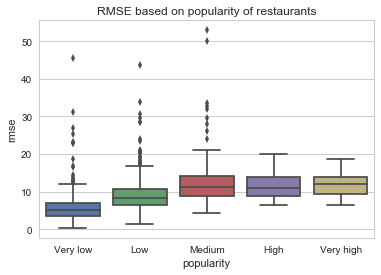

In [336]:
sns.boxplot(x="popularity", y="rmse", data=test_dataset_subset).set_title("RMSE based on popularity of restaurants")
plt.show()